# Using Maxent as base models
Yangkang Chen<br>
Sep 15, 2023

In [2]:
import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
import warnings
import pickle
import os
import json

# matplotlib.style.use('ggplot')
# plt.rcParams['axes.facecolor']='w'
# warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Please download the sample data from:
# https://figshare.com/articles/dataset/Sample_data_Mallard_csv/24080745
# Assuming now it's downloaded and saved as './Sample_data_Mallard.csv'

# you can also try other species like 
# https://figshare.com/articles/dataset/Sample_data_Alder_Flycatcher_csv/24080751
# https://figshare.com/articles/dataset/Sample_data_Short-eared_Owl_csv/24080742
# https://figshare.com/articles/dataset/Sample_data_Eurasian_Tree_Sparrow_csv/24080748


In [5]:
data = pd.read_csv(f'./Sample_data_Mallard.csv')
data = data.drop('sampling_event_identifier', axis=1)

# Get X and y

In [6]:
X = data.drop('count', axis=1)
y = data['count'].values


# First thing first: Spatio-temporal train test split

In [35]:
from stemflow.model_selection import ST_CV
CV = 5


# Train AdaSTEM hurdle model

In [36]:
from stemflow.model.AdaSTEM import AdaSTEM, AdaSTEMClassifier, AdaSTEMRegressor
from xgboost import XGBClassifier, XGBRegressor
from stemflow.model.Hurdle import Hurdle_for_AdaSTEM, Hurdle
import elapid as ela


In [47]:
## create model instance
model = AdaSTEMClassifier(base_model=ela.MaxentModel(transform='cloglog', beta_multiplier=2.0),
                                save_gridding_plot = True,
                                ensemble_fold=10, 
                                min_ensemble_required=7,
                                grid_len_lon_upper_threshold=50,
                                grid_len_lon_lower_threshold=5,
                                grid_len_lat_upper_threshold=50,
                                grid_len_lat_lower_threshold=5,
                                temporal_step=50,
                                temporal_bin_interval=50,
                                points_lower_threshold=100, njobs=4)


In [48]:
CV_generator = ST_CV(X, y, 
                    Spatio_blocks_count = 50, Temporal_blocks_count=50,
                    random_state=42, CV=CV)


metric_dict_list = []
for X_train, X_test, y_train, y_test in tqdm(CV_generator, total=CV):
    ## fit model
    model.fit(X_train, np.where(y_train>0,1,0), verbosity=0)
    ## predict
    pred_adastem = model.predict(X_test, verbosity=0)
    ## save prediction results
    pred_df = pd.DataFrame({
                'y_true':y_test.flatten(),
                'y_pred_adastem':np.where(pred_adastem.flatten()<0, 0, pred_adastem.flatten()),
            }).dropna()

    ## calculate metrics
    metric_dict = AdaSTEM.eval_STEM_res('hurdle', np.array(pred_df.y_true).flatten(), 
                                                np.where(np.array(pred_df.y_pred_adastem).flatten()<0, 0, np.array(pred_df.y_pred_adastem).flatten())
                                                )
    metric_dict_list.append(metric_dict)
    


100%|██████████| 5/5 [3:14:47<00:00, 2337.55s/it]  


In [49]:
adastem_metrics = pd.DataFrame(metric_dict_list)[['AUC','kappa','f1','precision','recall','average_precision']]
adastem_metrics

,AUC,kappa,f1,precision,recall,average_precision
0,0.736316,0.401915,0.526669,0.445225,0.644579,0.349655
1,0.720966,0.377922,0.509609,0.432525,0.620129,0.336472
2,0.727614,0.387215,0.520642,0.439436,0.638664,0.347057
3,0.724253,0.382455,0.512133,0.433795,0.625000,0.337823
4,0.727759,0.390803,0.521628,0.443649,0.632864,0.347826


In [50]:
adastem_metrics.to_csv('./Maxent_AdasTEM_metrics.csv', index=False)


# Compared to simple Maxent model

In [41]:
## create model instance
model_me = ela.MaxentModel(transform='cloglog', beta_multiplier=2.0)

In [43]:
CV_generator = ST_CV(X, y, 
                    Spatio_blocks_count = 50, Temporal_blocks_count=50,
                    random_state=42, CV=CV)

metric_dict_list = []
for X_train, X_test, y_train, y_test in tqdm(CV_generator, total=CV):
    ## fit model
    model_me.fit(X_train.drop(['longitude','latitude'], axis=1), np.where(y_train>0,1,0))
    ## predict on test set
    pred_me = model_me.predict(X_test.drop(['longitude','latitude'], axis=1))
    ## save prediction results
    pred_df = pd.DataFrame({
        'y_true':y_test.flatten(),
        'y_pred':np.where(pred_me.flatten()>0.5, 1, 0)
    }).dropna()
    ## calculate metrics
    metrics_me = AdaSTEM.eval_STEM_res('hurdle', pred_df.y_true, pred_df.y_pred)
    metric_dict_list.append(metrics_me)
    



  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [3:48:12<00:00, 2738.41s/it]  


In [44]:
maxent_metrics = pd.DataFrame(metric_dict_list)[['AUC','kappa','f1','precision','recall','average_precision']]
maxent_metrics

,AUC,kappa,f1,precision,recall,average_precision
0,0.721753,0.325763,0.471622,0.359857,0.684088,0.298320
1,0.706076,0.306849,0.458735,0.352637,0.656152,0.289303
2,0.714194,0.318858,0.471624,0.362087,0.676178,0.300594
3,0.708874,0.320062,0.465677,0.364793,0.643690,0.294589
4,0.711749,0.316275,0.468793,0.360737,0.669266,0.298200


In [45]:
maxent_metrics.to_csv('./Maxent_simple_metrics.csv', index=False)


# Comparing AdaSTEM-Maxent & Maxent

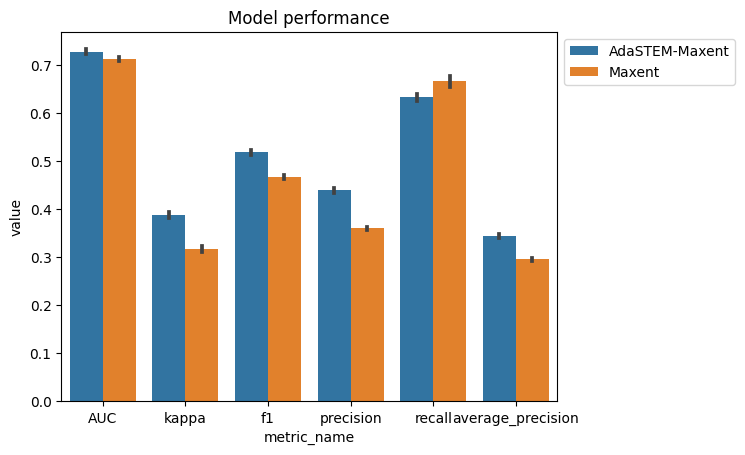

In [71]:

import seaborn as sns
adastem_metrics['model'] = 'AdaSTEM-Maxent'
maxent_metrics['model'] = 'Maxent'
new_dat = pd.concat([adastem_metrics, maxent_metrics], axis=0)
dat_for_plot = []
for index,row in new_dat.iterrows():
    for metric_name in ['AUC', 'kappa', 'f1', 'precision', 'recall', 'average_precision']:
        dat_for_plot.append({
            'model':row['model'],
            'metric_name':metric_name,
            'value':row[metric_name]
        })
dat_for_plot = pd.DataFrame(dat_for_plot)

sns.barplot(data=dat_for_plot, errorbar=('ci', 95), 
            x="metric_name", y="value", hue="model")
plt.title('Model performance')
plt.legend(bbox_to_anchor=(1,1))
plt.show()


In [72]:
from watermark import watermark
print(watermark())
print(watermark(packages="stemflow,numpy,scipy,pandas,xgboost,tqdm,matplotlib,h3pandas,geopandas,scikit-learn,watermark"))


Last updated: 2023-09-15T10:05:30.738065+08:00

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 21.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

stemflow    : 0.0.20
numpy       : 1.25.2
scipy       : 1.11.2
pandas      : 2.1.0
xgboost     : 2.0.0
tqdm        : 4.66.1
matplotlib  : 3.7.3
h3pandas    : 0.2.4
geopandas   : 0.13.2
scikit-learn: 1.3.0
watermark   : 2.4.3

